In [1]:
from skimage import io,filters, morphology, measure, draw,exposure
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import trackpy as tp
import pandas as pd
import math
from scipy.stats import median_abs_deviation
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
import matplotlib
import seaborn as sns
from skimage.filters import threshold_otsu
from matplotlib import rc
import matplotlib as mpl

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
PATH = '<PATH/TO/DIR/>WAVE/Linear_vs_planar/Control_SPARK/'

In [4]:
def CalMean(result,para,n):
    """
    Calculate the average normalized intensity between groups
    
    Parameters
    ----------
    result: DataFrame
        containing ALL of the lamellipodia quantification info (multiple groups)
    para: string
        parameter on the x axis for plotting
    n: inta
        number of sections for calculating the mean
    
    Returns
    -------
    mean: array
        containing the calculated mean
    std: array
        containing the calculated standard deviation
    xaxis: array
        containing the regrouped xaxis 
    
    """
    region = np.linspace(0,1,n)
    mean = []
    std = []
    xaxis = []
    maximum = result[para].max()
    minimum = result[para].min()
    step = (maximum-minimum)/n
    for p in range(len(region)-1):
        data = result[(result[para] <minimum+step*(p+1)) & (result[para] >=minimum+step*p)]['nor_intensity']
        if data.empty:
            continue
        else:
            mean_intensity = data.mean()
            std_intensity = data.std()
            xaxis.append((minimum+step*(p+0.5)))
            if np.isnan(mean_intensity):
                mean.append(data)
            else:
                mean.append(mean_intensity)
            if np.isnan(std_intensity):
                std.append(0)
            else:
                std.append(std_intensity)
    return mean,std, xaxis

In [5]:
def seg_cells(image, threshold, sigma,min_size, max_size, plot = True):
    """
    Segment out regions with a given fluorescence threshold in a cell
 
    Parameters
    ----------
    image : 2D array
        Raw tif image (single frame).
    threshold: float
        threshold used for segmentation
    sigma: float
        Standard deviation for Gaussian kernel.The larger the value, the smoothier the gaussian fitting.
    min_size: float
        minimum size of the segmented region
    max_size: float
        maximum size of the segmented region
    plot: bool
        whether or not plot the segmentation image
    
    Returns
    -------
    region_properties: list of RegionProperties
        Each item describes one labeled region with the corresponding attributes. 
    label_mask_clean:2D array 
        Segmentations based on fluorescent intensities of the image. 
        Each integer corresponds to a unique segmentation and 0 is the background.
        
    """
    smooth = filters.gaussian(image,sigma,preserve_range=True)
    cell_mask = smooth > threshold
    label_mask = measure.label(cell_mask)
    region_properties = measure.regionprops(label_mask)  
    label_mask_clean = label_mask.copy()
    for r in region_properties:
        if r.area <= min_size or r.area >= max_size:
            label_mask_clean[label_mask_clean == r.label] = 0
    if plot:
        plt.figure(figsize = (10,10))
        plt.imshow(image)
        plt.contour(label_mask_clean,colors = 'r',linewidths = 0.7)

    region_properties = measure.regionprops(label_mask_clean,intensity_image=image)
    return region_properties,label_mask_clean

In [6]:
def f_x(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

In [7]:
def f_x2(x,A,B):
    return A * np.power(x,2) +B

In [8]:
result_spark = pd.DataFrame()

In [21]:
image = io.imread(PATH + 'example_images/230614_pmw64_002_SIR.tif')

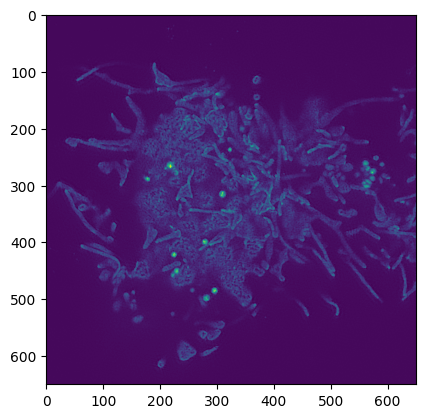

In [24]:
plt.imshow(image)

In [25]:
threshold_otsu(image)

638.0231

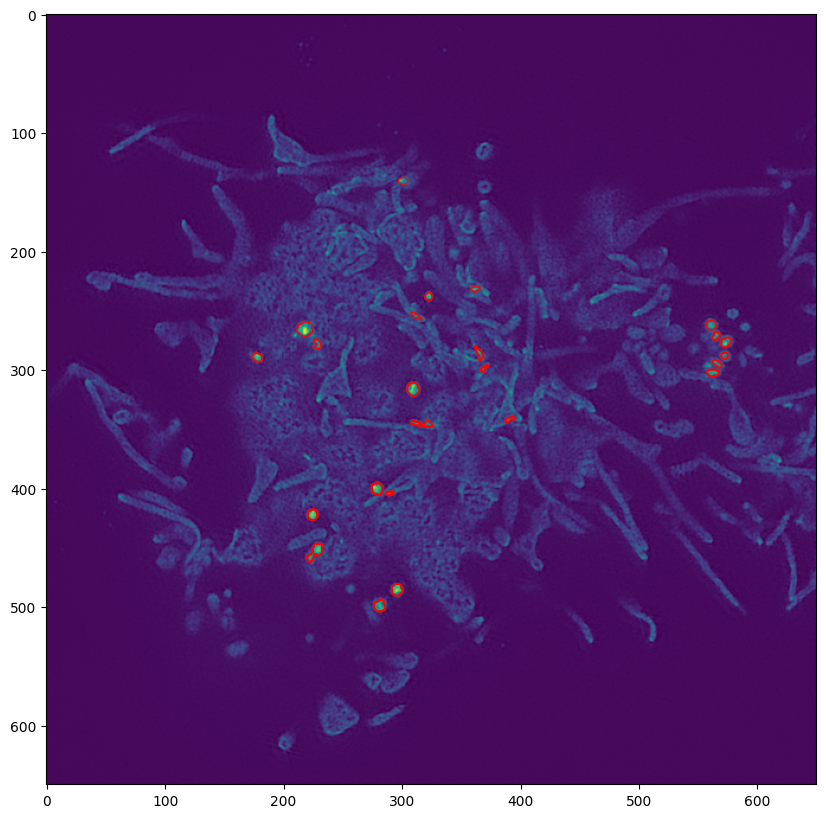

In [26]:
threshold = 2000
b_min = 15
b_max = 1200
label_mask_clean,droplets_features= seg_cells(image,threshold,1,b_min,b_max)

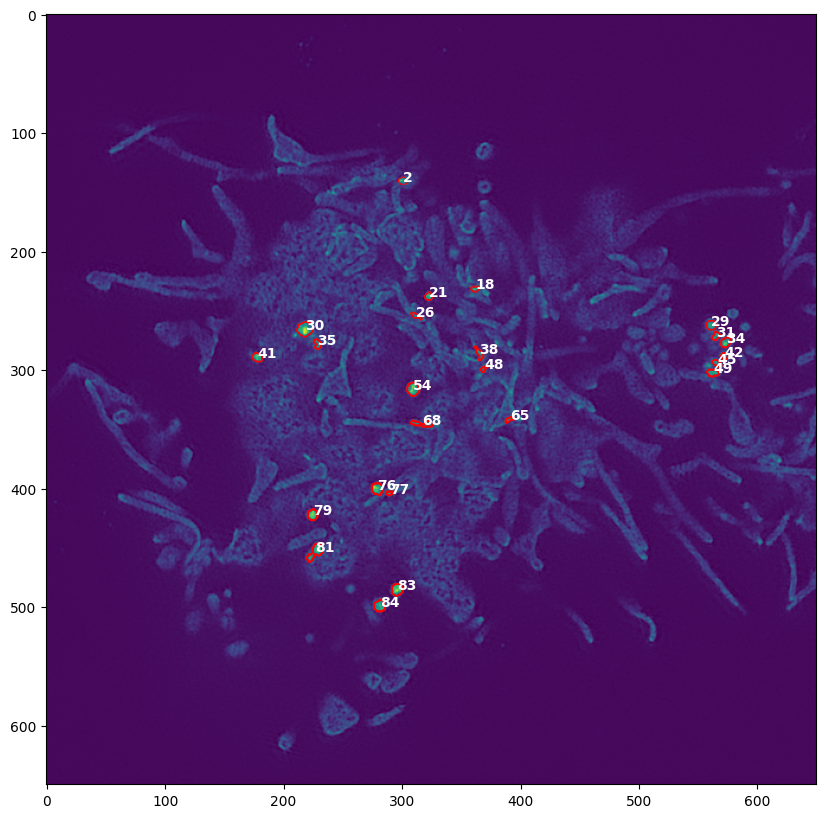

In [27]:
features = pd.DataFrame()
droplets_features,label_mask_clean= seg_cells(image,threshold,1,b_min,b_max,True)
for j in range(len(droplets_features)):
    y_center, x_center = droplets_features[j].centroid # note that image coordinates are often given as (y, x) rather than (x, y)
    plt.text(x_center, y_center, droplets_features[j].label, fontweight = 'bold', color = 'white')
    features = features.append([{'label':droplets_features[j].label,
                                 'x': droplets_features[j].centroid[0],
                                 'y': droplets_features[j].centroid[1],
                                 'major': droplets_features[j].axis_major_length,
                                 'minor': droplets_features[j].axis_minor_length,
                                 'area': droplets_features[j].area,
                                 'bbox': droplets_features[j].bbox,
                                 'intensities': droplets_features[j].intensity_image.sum()}])

In [28]:
features['r'] = (features['major']+features['minor'])/2

In [29]:
len(features)

24

In [30]:
# Keep the round ones
features = features[features.major/features.minor <1.3]

In [31]:
features['nor_intens'] = features['intensities']/features['intensities'].max()
features['nor_area'] = features['area']/features['area'].max()
features['nor_r'] = features['r']/features['r'].max()
features['nor_r2'] = features['nor_r']*features['nor_r']

In [32]:
features

,label,x,y,major,minor,area,bbox,intensities,r,nor_intens,nor_area,nor_r,nor_r2
0,21,237.689655,322.551724,6.258787,5.866530,29,"(235, 320, 241, 326)",93619.226562,6.062658,0.253164,0.256637,0.502625,0.252632
0,29,262.000000,561.086957,7.816419,7.460038,46,"(259, 558, 266, 566)",124426.687500,7.638229,0.336474,0.407080,0.633248,0.401003
0,30,265.300885,218.017699,12.636641,11.487346,113,"(260, 212, 272, 225)",369796.250000,12.061994,1.000000,1.000000,1.000000,1.000000
0,42,287.958333,572.291667,5.773503,5.286251,24,"(286, 570, 291, 576)",58121.582031,5.529877,0.157172,0.212389,0.458455,0.210181
0,54,315.988235,309.352941,11.080869,9.760436,85,"(311, 305, 322, 315)",281938.875000,10.420652,0.762417,0.752212,0.863925,0.746366
0,76,400.150685,279.027397,10.171253,9.165474,73,"(396, 275, 406, 284)",241332.453125,9.668364,0.652609,0.646018,0.801556,0.642492
0,79,422.067797,224.525424,9.027382,8.265639,59,"(418, 221, 427, 229)",207869.078125,8.646511,0.562118,0.522124,0.716839,0.513859
0,83,485.281690,295.774648,9.984993,9.061187,71,"(481, 292, 491, 301)",247166.453125,9.523090,0.668386,0.628319,0.789512,0.623329
0,84,498.929577,281.112676,9.899074,9.264908,71,"(494, 277, 504, 286)",208151.109375,9.581991,0.562881,0.628319,0.794395,0.631064


# Generate plots

In [33]:
result_spark_g1 = pd.read_csv(PATH + 'csv_data/result_spark_g1.csv',index_col = 0)
result_spark_g2 = pd.read_csv(PATH + 'csv_data/result_spark_g2.csv',index_col = 0)
result_spark_g3 = pd.read_csv(PATH + 'csv_data/result_spark_g3.csv',index_col = 0)

In [34]:
result_spark = result_spark_g1

In [35]:
result_spark = result_spark.append(result_spark_g2)
result_spark = result_spark.append(result_spark_g3)

In [36]:
mean_spark,std_spark,area_spark = CalMean(result_spark,'nor_r2',25)

In [37]:
popt, pcov = curve_fit(f_x, result_spark['nor_r2'], result_spark.nor_intensity)

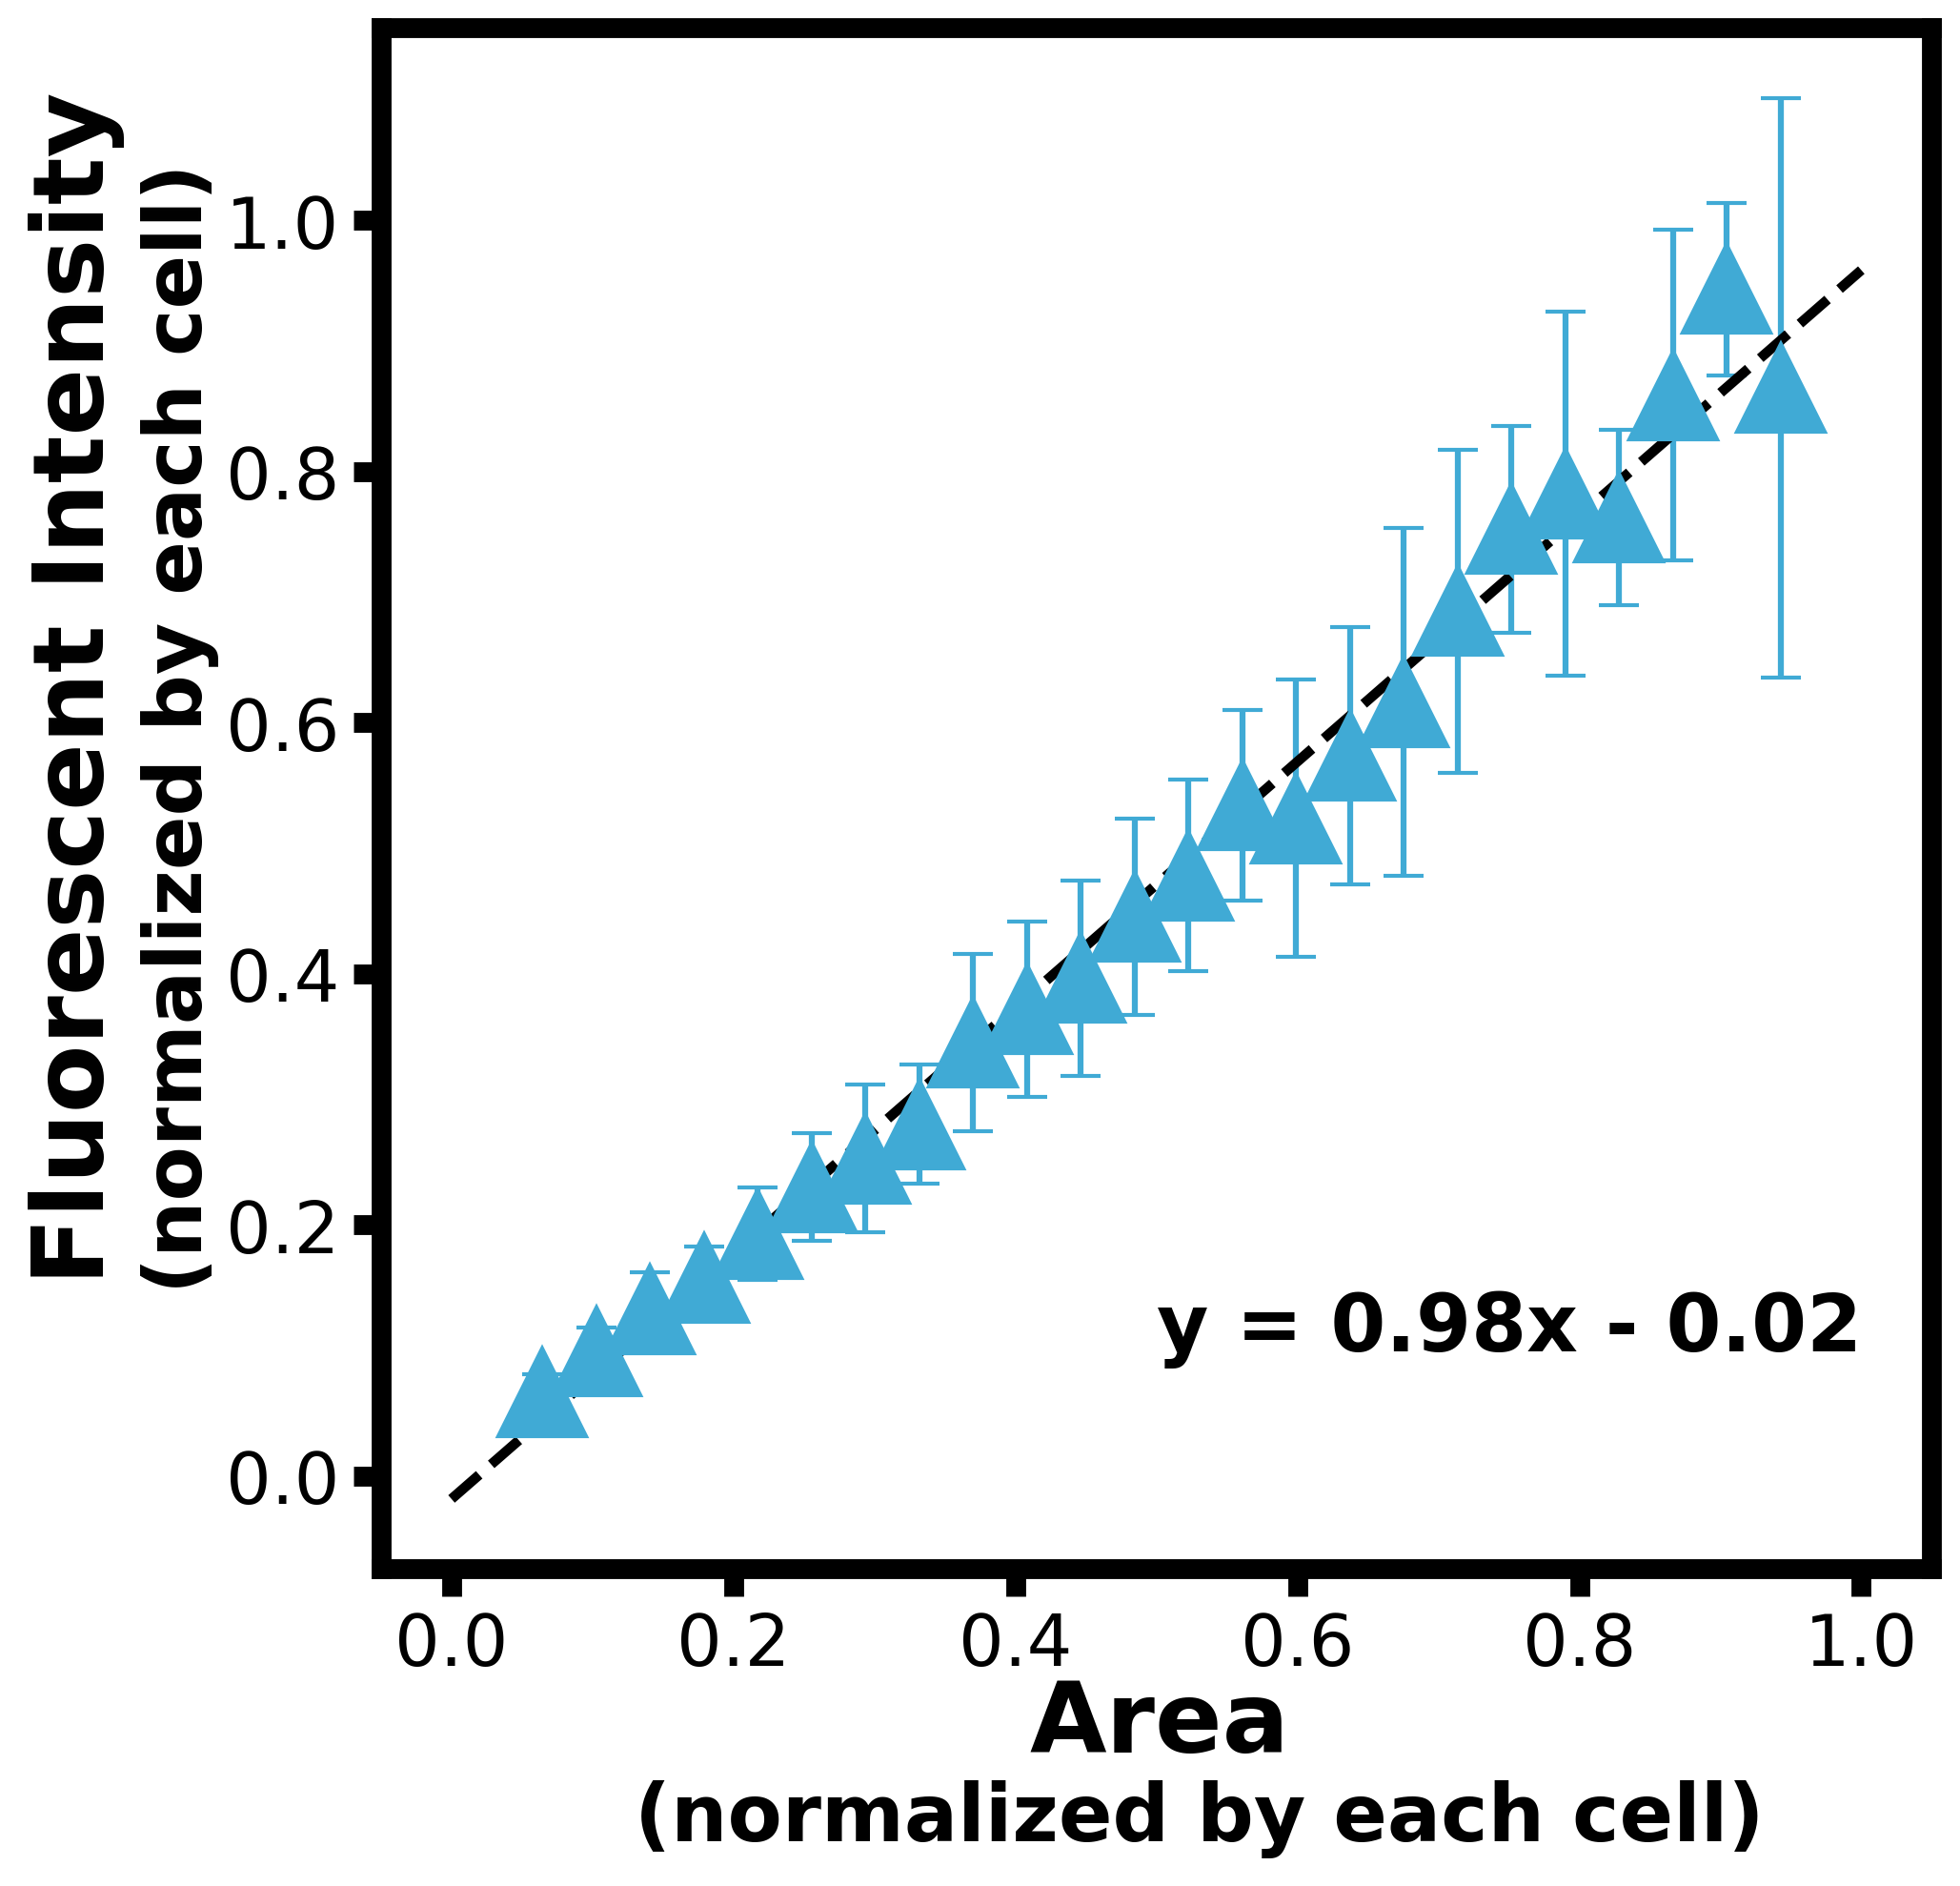

In [38]:
_,ax = plt.subplots(figsize = (7,7),dpi = 300)
plt.errorbar(area_spark, mean_spark, std_spark, linestyle='None',capsize = 5, marker='^',markersize = 22,color = '#40aad5')
x = np.linspace(0,1,10)
plt.plot(x,f_x(x,popt[0],popt[1]),ls = 'dashed',color = 'black',lw = 2.5)
plt.text(-0.3,0.17,'Fluorescent Intensity',size= 25,rotation = 'vertical',fontweight = 'bold')
plt.text(-0.22,0.16,'(normalized by each cell)',size= 20,rotation = 'vertical',fontweight = 'bold')
plt.text(0.41,-0.22,'Area',size= 25,fontweight = 'bold')
plt.text(0.13,-0.29,'(normalized by each cell)',size= 20,fontweight = 'bold')
plt.yticks(size = 18)
plt.xticks(size = 18)
plt.text(0.5,0.1,'y = ' + "{:.2f}x - {:.2f}".format(popt[0],-popt[1]),size = 20,fontweight = 'bold')
# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(5)

# increase tick width
ax.tick_params(width=5, size= 7)
plt.savefig(PATH + "FigS1F_intensity_vs_area.png",bbox_inches = 'tight',dpi = 300)

In [39]:
mean_spark,std_spark,diameter_spark = CalMean(result_spark,'nor_r',25)

In [40]:
popt, pcov = curve_fit(f_x2, result_spark['nor_r'], result_spark.nor_intensity)

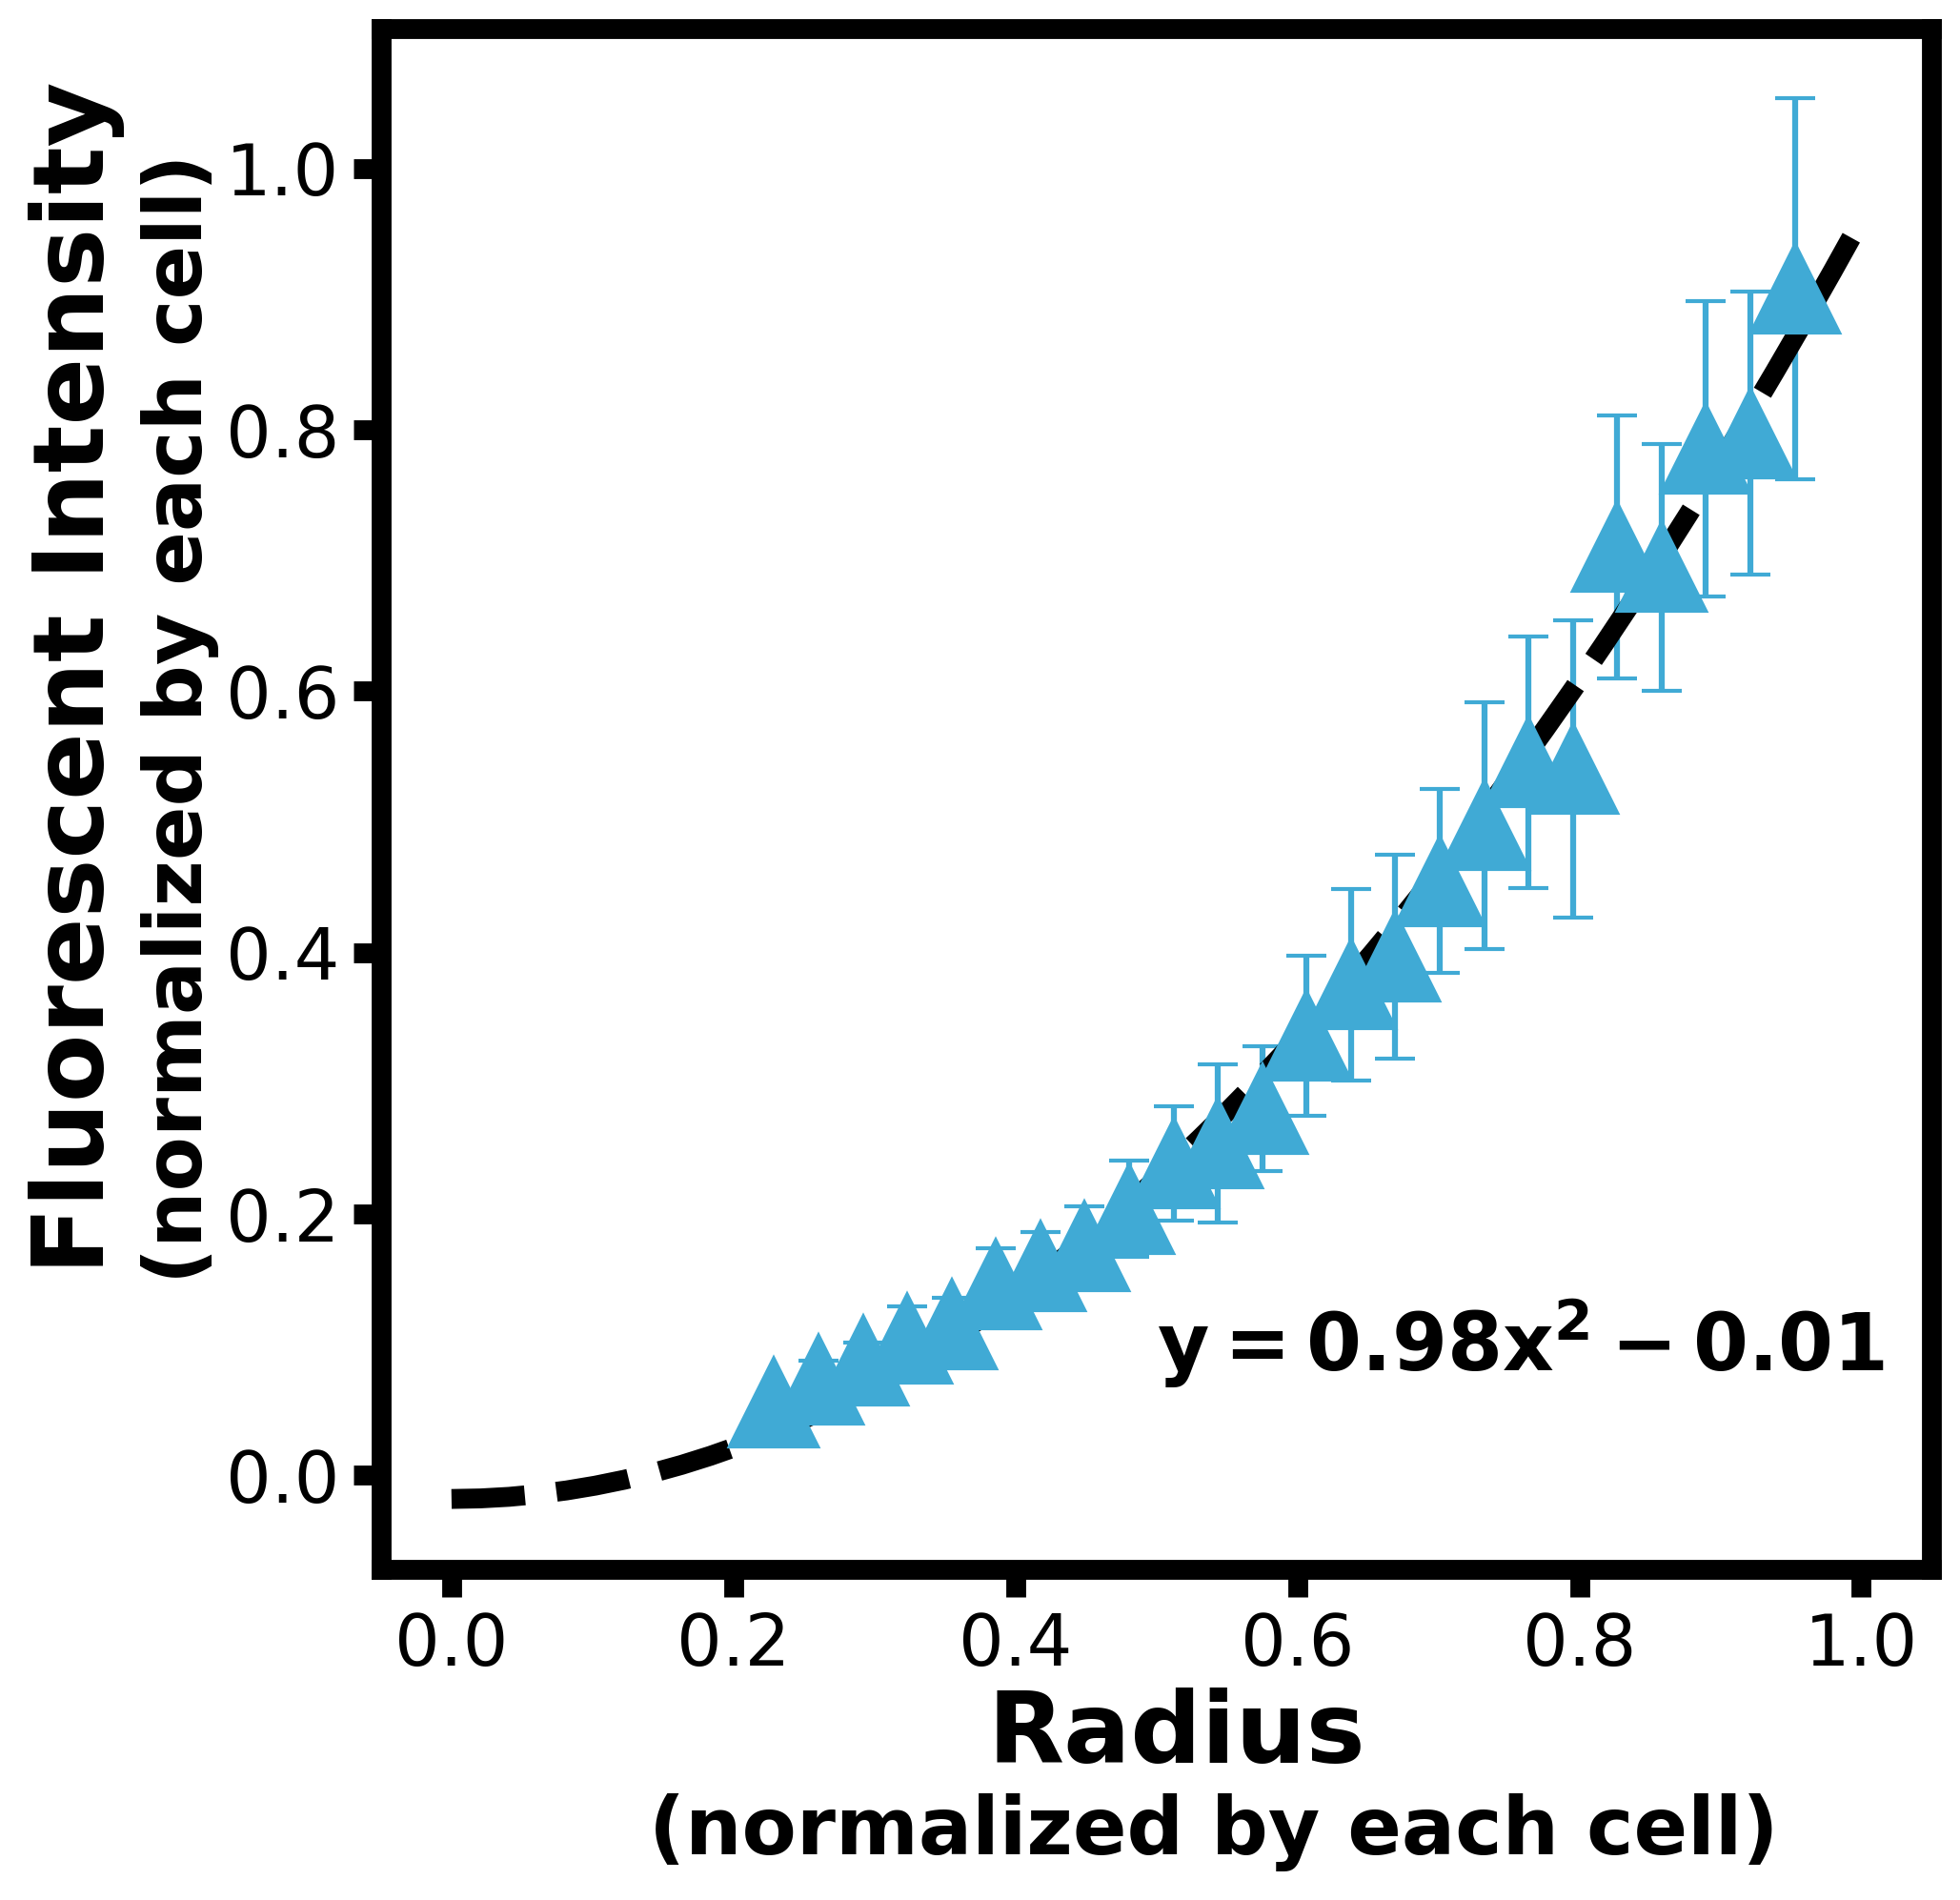

In [41]:
_, ax = plt.subplots(figsize = (7,7),dpi = 300)
plt.errorbar(diameter_spark, mean_spark, std_spark, linestyle='None',capsize = 5, marker='^',markersize = 22,color = '#40aad5')
x = np.linspace(0,1,50)

plt.text(0.5,0.08,r'$\mathbf{y = 0.98x^{2} - 0.01}$',size = 20,fontweight = 'bold')
plt.text(-0.3,0.17,'Fluorescent Intensity',size= 25,rotation = 'vertical',fontweight = 'bold')
plt.text(-0.22,0.16,'(normalized by each cell)',size= 20,rotation = 'vertical',fontweight = 'bold')
plt.text(0.38,-0.22,'Radius',size= 25,fontweight = 'bold')
plt.text(0.14,-0.29,'(normalized by each cell)',size= 20,fontweight = 'bold')
plt.plot(x,f_x2(x,popt[0],popt[1]),ls = 'dashed',color = 'black',lw = 5)
plt.yticks(size = 18)
plt.xticks(size = 18)

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(5)

# increase tick width
ax.tick_params(width=5, size=7)
plt.savefig(PATH + "Fig2J_intensity_vs_perimeter.png",bbox_inches = 'tight',dpi = 300)